<a href="https://colab.research.google.com/github/Sujangyawali/Fraud_Detection/blob/master/pyspark_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install pyspark

     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 198 kB 66.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=a85054009afa1c0a0c2bbe10975f79cab41b0974ed4ef06eb6efd9f664686a78
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle datasets list


     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4135e8d69a5d1c263795af790fde230a62ef2765b82c0d0548778c25aaeac4a8
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-16 08:33:52     

In [4]:
! kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 25.1MB/s]


In [5]:
! unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [58]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [7]:
from pyspark import SparkContext
from pyspark.sql import SparkSession #entry point for data frame and SQL funtionality

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
spark=SparkSession.builder.appName('Pyspark For classification').getOrCreate()

In [10]:
data=spark.read.csv('/content/train.csv',header=True,inferSchema=True)
#"header=True, if not  set to true treat header as data record infershema :automatically guess datatype of column "

In [11]:
data.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [12]:
data.take(3)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C'),
 Row(PassengerId=3, Survived=1, Pclass=3, Name='Heikkinen, Miss. Laina', Sex='female', Age=26.0, SibSp=0, Parch=0, Ticket='STON/O2. 3101282', Fare=7.925, Cabin=None, Embarked='S')]

In [13]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [14]:
#conversion form spark dataframe to pandas dataframe 
pandas_data=data.toPandas()

In [15]:
pandas_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of age')

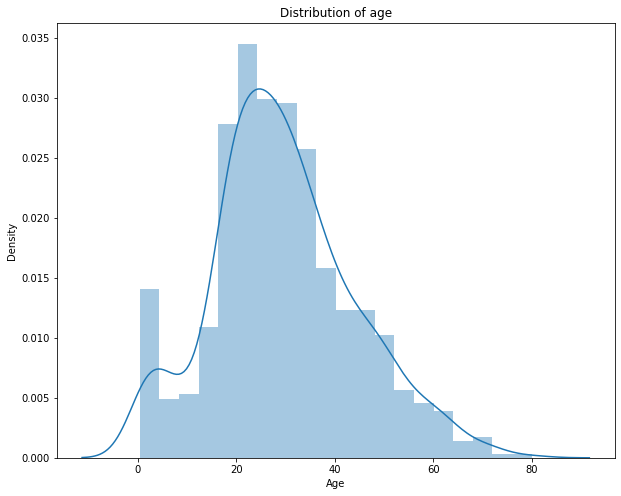

In [16]:
f,ax=plt.subplots(figsize=(10,8))
sns.distplot(pandas_data['Age'])
ax.set_title('Distribution of age')

In [17]:
#checking null values in spark 
from pyspark.sql.functions import isnan,when,count,col ,isnull,column

In [18]:
data.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [19]:
data.select(['Age','Sex']).show(5)

+----+------+
| Age|   Sex|
+----+------+
|22.0|  male|
|38.0|female|
|26.0|female|
|35.0|female|
|35.0|  male|
+----+------+
only showing top 5 rows



In [23]:
from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [24]:
data.drop('Cabin')

DataFrame[PassengerId: int, Survived: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Embarked: string]

In [26]:
nam='Braund, Mr. Owen Harris'

In [34]:
nam.split(',')[1].split('.')[0].strip()

'Mr'

In [48]:
data=data.withColumn('Initial',regexp_extract(col('Name'),"([A-Za-z]+)\.",1))

In [49]:
data.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,Mr


In [71]:
data.select('Initial').distinct().show()

+--------+
| Initial|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



In [73]:
data = data.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [74]:
data.select('Initial').distinct().show()

+-------+
|Initial|
+-------+
|   Miss|
|  Other|
| Master|
|     Mr|
|    Mrs|
+-------+



In [80]:
data.groupBy('Initial').count().show()

+-------+-----+
|Initial|count|
+-------+-----+
|   Miss|  186|
|  Other|    9|
| Master|   40|
|     Mr|  529|
|    Mrs|  127|
+-------+-----+



Imputation of missing values

In [78]:
data.groupBy('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [79]:
data = data.withColumn("Age",when((data["Initial"] == "Miss")   & (data["Age"].isNull()), 22).otherwise(data["Age"]))
data = data.withColumn("Age",when((data["Initial"] == "Other")  & (data["Age"].isNull()), 46).otherwise(data["Age"]))
data = data.withColumn("Age",when((data["Initial"] == "Master") & (data["Age"].isNull()), 5).otherwise( data["Age"]))
data = data.withColumn("Age",when((data["Initial"] == "Mr")     & (data["Age"].isNull()), 33).otherwise(data["Age"]))
data = data.withColumn("Age",when((data["Initial"] == "Mrs")    & (data["Age"].isNull()), 36).otherwise(data["Age"]))

In [81]:
data.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [82]:
data=data.na.fill({'Embarked':"S"})

Feature Engineering

In [83]:
data=data.withColumn('Family_Size',col('Sibsp')+col('Parch'))

In [86]:
data=data.withColumn('Alone',lit(0))
data = data.withColumn("Alone",when(data["Family_Size"] == 0, 1).otherwise(data["Alone"]))

In [87]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)

In [91]:
data.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,Miss,0,1,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,0,1.0,0.0,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,Mr,0,1,0.0,0.0,0.0
5,6,0,3,"Moran, Mr. James",male,33.0,0,0,330877,8.4583,None,Q,Mr,0,1,0.0,2.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,0,1,0.0,0.0,0.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S,Master,4,0,0.0,0.0,3.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S,Mrs,2,0,1.0,0.0,2.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C,Mrs,1,0,1.0,1.0,2.0


In [93]:
#dropping feature that are not neded in modeling
data = data.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = data.columns[1:],outputCol="features")
feature_vector= feature.transform(data)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [95]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

In [97]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.7867298578199052
Precision:  0.7923625802994501
